In [1]:
### going to use the same steps to create data, and then try to use the kernal method###

In [2]:
import numpy as np

**Importing MNIST dataset using Tensorflow**

In this step, we assume you have intmernet connectivity. Connectivity is necessary for this tutorial because the tensorflow library imports the dataset from https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz by default. If you do not have internet connectivity, for some strange reason, you can follow our "How to import the MNIST dataset from a local directory" tutorial.

To load the MNIST dataset, use the following code:

In [3]:
from tensorflow.keras.datasets import mnist

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


The MNIST dataset will be loaded as a set of training and test inputs (X) and outputs (Y). The imputs are samples of digit images while the outputs contain the numerical value each input represents. The exact shape of each dataset is provided below for your convenience.

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() #loads everything, we only want some specific stuff

In [5]:
print('MNIST Dataset Shape:')
print('x_train: ' + str(x_train.shape))
print('y_train: ' + str(y_train.shape))
print('x_test:  '  + str(x_test.shape))
print('y_test:  '  + str(y_test.shape))

MNIST Dataset Shape:
x_train: (60000, 28, 28)
y_train: (60000,)
x_test:  (10000, 28, 28)
y_test:  (10000,)


In [6]:
x_train[0].shape

(28, 28)

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from qiskit.algorithms.optimizers import ADAM, SPSA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit.primitives import BackendEstimator, BackendSampler
from qiskit.quantum_info import Pauli
from qiskit_aer import AerSimulator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient, ParamShiftSamplerGradient

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss

C:\Users\sebts\AppData\Local\Temp\ipykernel_11604\4053146574.py:8: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import ADAM, SPSA


**Load the MNIST Dataset**

MNIST dataset consists of thousand images of hand-written digits from 0 to 9. Every image has 28x28 pixels and every pixel's value is between 0 to 255. This dataset is too large for us. So we need to reduce it.

1). Normalizing the pixel's value in the range of [0,1].

2). Filtering images from the dataset, leaving only the images with number 3 and 6 as their labels.

3). Reducing the total number of images in the dataset and divide the dataset into training dataset and testing dataset.

4). Resize the image from 28x28 pixels to 16x16 pixels because QPCA needs the size of the image in the form of 2^n x 2^n pixels.

In [8]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0 #this rescales the int intensity to 0-1 float
#also for some reason adds another axis? (see shape below)

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))
     

Number of original training examples: 60000
Number of original test examples: 10000


In [9]:
print(x_train.shape) # from (60000, 28, 28)?
print(x_train[0].shape) #-- a single image but with an extra set of []
print(x_train[0])

(60000, 28, 28, 1)
(28, 28, 1)
[[[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.

In [10]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [11]:
# choose the number to be classified here, in this case I selected number 0 and 1
number_set = [0, 1]

mask_train = np.isin(y_train, number_set) #is in is useful
mask_test = np.isin(y_test, number_set)

x_train = x_train[mask_train]
y_train = y_train[mask_train]
x_test = x_test[mask_test]
y_test = y_test[mask_test]

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))
     

Number of filtered training examples: 12665
Number of filtered test examples: 2115


In [12]:
y_train # check we only have 1 and 0

array([0, 1, 1, ..., 1, 0, 1], dtype=uint8)

In [13]:
y_train.shape

(12665,)

In [14]:
# next, reduce the number of images inside the dataset

index_train = np.array([], dtype=int)
index_test = np.array([], dtype=int)

# decide how many images we want inside the dataset
num_data = 100
# decide what is the percentage of the dataset we want for the training dataset
train_percentage = 0.8

# train data
counter = np.array([0,0], dtype=int)
for i in range (len(x_train)):
    if y_train[i] == True and counter[0] < int(train_percentage*num_data/2): # num_data/2 because we want a 50-50 split of 1's and 0's
        index_train = np.append(index_train, np.array([int(i)]), axis=0)
        counter[0] += 1

    if y_train[i] == False and counter[1] < int(train_percentage*num_data/2): # the == True and False works to select 0 and 1
        index_train = np.append(index_train, np.array([int(i)]), axis=0)
        counter[1] += 1

# test data
counter = np.array([0,0], dtype=int)
for i in range (len(x_test)):
    if y_test[i] == True and counter[0] < int(np.round(1-train_percentage, 2)*num_data/2):
        index_test = np.append(index_test, np.array([int(i)]), axis=0)
        counter[0] += 1

    if y_test[i] == False and counter[1] < int(np.round(1-train_percentage, 2)*num_data/2):
        index_test = np.append(index_test, np.array([int(i)]), axis=0)
        counter[1] += 1

x_train = x_train[index_train]
y_train = y_train[index_train]
x_test = x_test[index_test]
y_test = y_test[index_test]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(80, 28, 28, 1) (80,)
(20, 28, 28, 1) (20,)


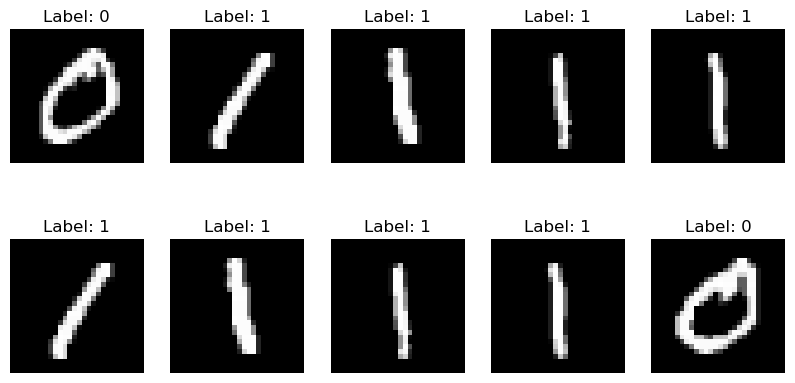

In [15]:
# Print some images from the final dataset
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i in range(2):
    for j in range(5):
        axes[i, j].imshow(x_train[i + j].squeeze(), cmap='gray') #imshow() is for images, and cmap grey i think interprets 0-1
        # the .squeeze() removes and dimensions of 1, so the extra dimension we added?
        axes[i, j].set_title("Label: {}".format(y_train[i + j]))
        axes[i, j].axis('off')

plt.show()

0


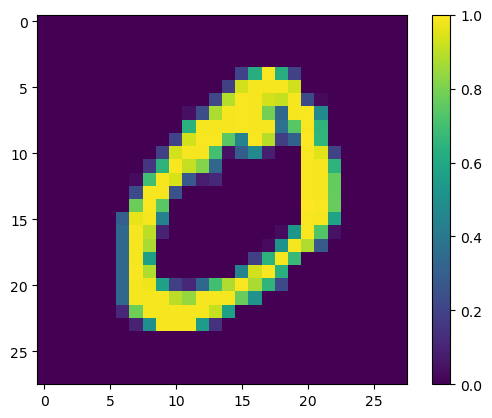

In [16]:
# plot an example of 1 image

print(y_train[0])

plt.imshow(x_train[0, :, :, 0]) #this is 1st image [0, data :,:, and then removing last dim 0]
plt.colorbar()

In [17]:
# resize the images

x_train_small = tf.image.resize(x_train, (16,16)).numpy() #tf is tensor flow, which I imagine is the resizing method?
x_test_small = tf.image.resize(x_test, (16,16)).numpy() #.numpy() puts into np array?
print(x_train_small.shape)
len(x_train_small)

(80, 16, 16, 1)


80

0


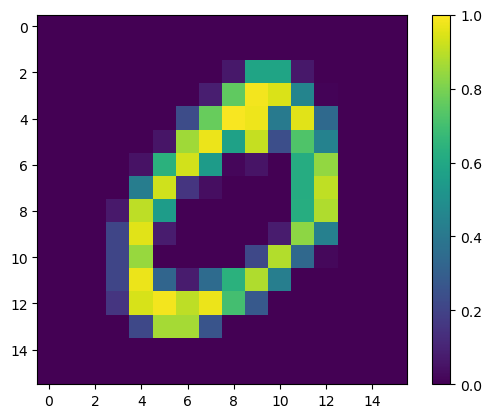

In [18]:
# plot an example of 1 resized image

print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

**Classical Principal Component Analysis**

We will use the well-known scikit-learn package for the classical PCA (https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

In [19]:
# decide the number of principal components to be used
#from sklearn.decomposition import PCA -- can do 2^n pixels, (16x16=256) above it says 2^n x 2^n but this doesn't seem right
n_components_classic = 8

pca = PCA(n_components=n_components_classic, whiten = False, random_state = 2020) #reduces dimensionality

In [20]:
x_train_small_pca = pca.fit_transform(x_train_small.reshape(len(x_train_small),16**2)) #reshapes to 80,256 then reduces to 80,8 using pca
x_test_small_pca = pca.fit_transform(x_test_small.reshape(len(x_test_small),16**2))
x_train_small_pca.shape, x_test_small_pca.shape

((80, 8), (20, 8))

In [21]:
print(x_train_small_pca[0]) #not normalised, hence next step, could probably wait until this point to normalise?

[ 2.149694   -1.0433712  -0.18994118 -1.1095574  -0.06876877  0.44443968
  0.78277516  0.3613933 ]


**Dataset Reformatting**

VQC class from Qiskit need a specific format for the dataset. This section is dedicated to do that. 
You can read the documentation here (https://qiskit.org/documentation/stubs/qiskit.aqua.algorithms.VQC.html). THIS LINK DOESN'T WORK BUT IT'S A VQC SO SIMILAR TO THE VQC EXAMPLE WE HAVE

In [22]:
def normalize(x):
  return (x - x.min())/(x.max() - x.min())

x_train_small_pca = normalize(x_train_small_pca)
x_test_small_pca = normalize(x_test_small_pca)

In [23]:
x_total = np.concatenate((x_train_small_pca, x_test_small_pca))
x_total.shape #so we could have just taken all data from test or train, just keeping convention of data set

(100, 8)

# here is where i'm trying to branch off
# 

In [24]:
###


### here is where i'm trying to branch off


###

In [28]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

mnist_feature_map = ZZFeatureMap(feature_dimension=n_components_classic, reps=2, entanglement="linear") #this is now 8D

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

mnist_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=mnist_feature_map)

In [26]:
#I don't think I need onehot for this?
'''
def get_one_hot_encoding(y): #this converts the labels 0,1 to vectors |0>,|1> (maybe transpose)
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels), dtype=int)[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

print(f"Label {y_train[2]} converted to {y_train_1h[2]}")
print(f"Label {y_train[0]} converted to {y_train_1h[0]}")'''

Label 1 converted to [0 1]
Label 0 converted to [1 0]


In [32]:
from sklearn.svm import SVC

mnist_svc = SVC(kernel=mnist_kernel.evaluate)

ker = mnist_svc.fit(x_train_small_pca, y_train) #trying to save the fit

mnist_score_callable_function = mnist_svc.score(x_test_small_pca, y_test)

print(f"Callable kernel classification test score: {mnist_score_callable_function}") #works fairly good for test data

Callable kernel classification test score: 0.85


In [31]:
mnist_svc.score(x_train_small_pca, y_train) #seems to work perfectly for training data

1.0

In [35]:
y_train_pred = ker.predict(x_train_small_pca) #get the kernal method predictions for training data
y_test_pred = ker.predict(x_test_small_pca) #get the kernal method prediction for test data

In [41]:
print(y_train_pred)

[0 1 1 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0
 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 1 1 0 1 0 0 0
 1 0 0 0 0 0]


In [47]:
#corret answer mask
#not one hot (y_train not _1h and no need for axis=1)
train_pred_acc = y_train_pred == y_train
test_pred_acc = y_test_pred == y_test
print(test_pred_acc)

[False  True False  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True]


In [55]:
#split x data by whether the trained algo will give correct answer
#not one hot this time
x_all = np.concatenate((x_train_small_pca, x_test_small_pca))
y_all= np.concatenate((y_train, y_test))
y_pred_acc_all = np.concatenate((train_pred_acc, test_pred_acc))

x_b = x_all[y_all == 0]
x_b_good = x_b[(y_pred_acc_all[y_all == 0])]
x_b_bad = x_b[np.logical_not(y_pred_acc_all[y_all == 0])]

x_r = x_all[y_all == 1]
x_r_good = x_r[(y_pred_acc_all[y_all == 1])]
x_r_bad = x_r[np.logical_not(y_pred_acc_all[y_all == 1])]
#print(y_pred_acc_all)

In [56]:
x_b_good.shape #good 0's, all x data?

(50, 8)

In [57]:
x_b_good[0] #the 8 parameters for this data set

array([0.73806244, 0.25824726, 0.3864904 , 0.2483016 , 0.40469873,
       0.48181748, 0.53265846, 0.46933827], dtype=float32)

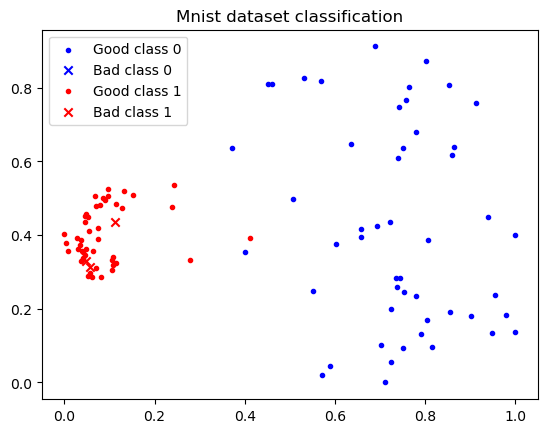

In [58]:
#plot whether the algo gives the correct outcome for each x, by the first two variables in x
plt.scatter(x_b_good[:,0], x_b_good[:,1], c='b', marker=".", label="Good class 0")
plt.scatter(x_b_bad[:,0], x_b_bad[:,1], c='b', marker="x", label="Bad class 0")
plt.scatter(x_r_good[:,0], x_r_good[:,1], c='r', marker=".", label="Good class 1")
plt.scatter(x_r_bad[:,0], x_r_bad[:,1], c='r', marker="x", label="Bad class 1")

plt.title("Mnist dataset classification")
plt.legend()

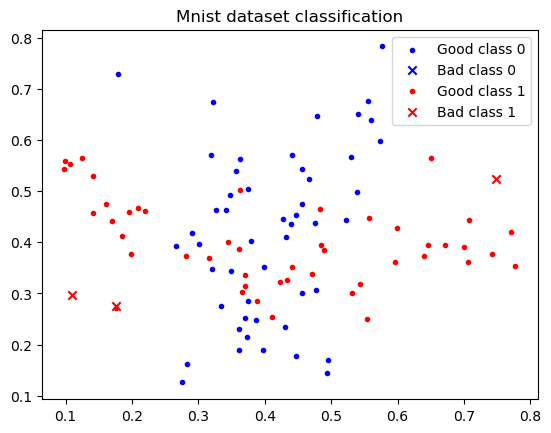

In [59]:
#plot whether the algo gives the correct outcome for each x, by 3rd and 4th variable in x
plt.scatter(x_b_good[:,2], x_b_good[:,3], c='b', marker=".", label="Good class 0")
plt.scatter(x_b_bad[:,2], x_b_bad[:,3], c='b', marker="x", label="Bad class 0")
plt.scatter(x_r_good[:,2], x_r_good[:,3], c='r', marker=".", label="Good class 1")
plt.scatter(x_r_bad[:,2], x_r_bad[:,3], c='r', marker="x", label="Bad class 1")

plt.title("Mnist dataset classification")
plt.legend()

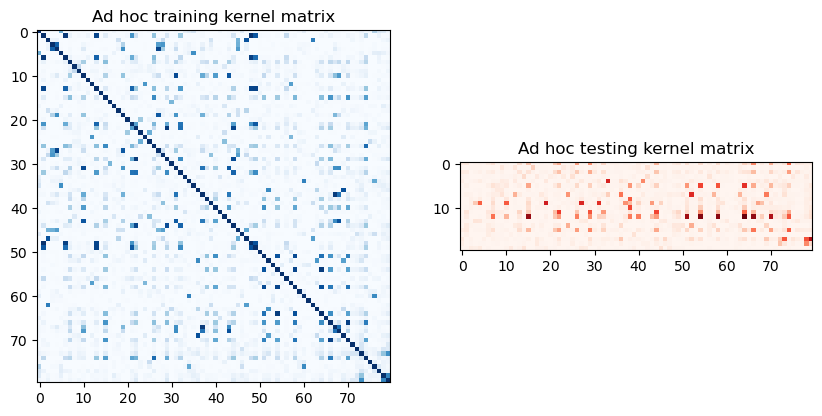

In [61]:
#pre computing the kernal matrices, to then use later
#it seems like the data is super diagonal, so this is a good method to use
mnist_matrix_train = mnist_kernel.evaluate(x_vec=x_train_small_pca)
mnist_matrix_test = mnist_kernel.evaluate(x_vec=x_test_small_pca, y_vec=x_train_small_pca)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(mnist_matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Ad hoc training kernel matrix")

axs[1].imshow(np.asmatrix(mnist_matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Ad hoc testing kernel matrix")

plt.show()

In [64]:
mnist_svc = SVC(kernel="precomputed")

mnist_svc.fit(mnist_matrix_train, y_train)

mnist_score_precomputed_kernel = mnist_svc.score(mnist_matrix_test, y_test)

print(f"Precomputed kernel classification test score: {mnist_score_precomputed_kernel}")

Precomputed kernel classification test score: 0.85


In [66]:
from qiskit_machine_learning.algorithms import QSVC

qsvc = QSVC(quantum_kernel=mnist_kernel) #use quantum kernal instead

qker = qsvc.fit(x_train_small_pca, y_train)

qsvc_score = qsvc.score(x_test_small_pca, y_test)

print(f"QSVC classification test score: {qsvc_score}")

y_train_qpred = qker.predict(x_train_small_pca) #get the qkernal method predictions for training data
y_test_qpred = qker.predict(x_test_small_pca) #get the qkernal method prediction for test data

QSVC classification test score: 0.85


In [67]:
#corret answer mask
#not one hot (y_train not _1h and no need for axis=1)
train_qpred_acc = y_train_qpred == y_train
test_qpred_acc = y_test_qpred == y_test
print(test_pred_acc)

[False  True False  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True]


In [68]:
#split x data by whether the trained algo will give correct answer
#not one hot this time
x_all = np.concatenate((x_train_small_pca, x_test_small_pca))
y_all= np.concatenate((y_train, y_test))
y_qpred_acc_all = np.concatenate((train_qpred_acc, test_qpred_acc))

x_b = x_all[y_all == 0]
x_b_good = x_b[(y_qpred_acc_all[y_all == 0])]
x_b_bad = x_b[np.logical_not(y_qpred_acc_all[y_all == 0])]

x_r = x_all[y_all == 1]
x_r_good = x_r[(y_qpred_acc_all[y_all == 1])]
x_r_bad = x_r[np.logical_not(y_qpred_acc_all[y_all == 1])]
#print(y_pred_acc_all)

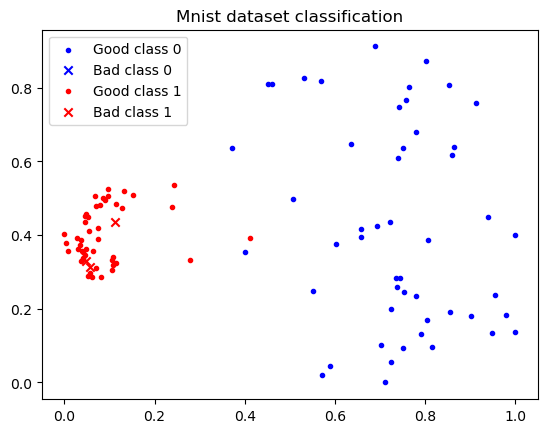

In [69]:
#plot whether the algo gives the correct outcome for each x, by the first two variables in x
plt.scatter(x_b_good[:,0], x_b_good[:,1], c='b', marker=".", label="Good class 0")
plt.scatter(x_b_bad[:,0], x_b_bad[:,1], c='b', marker="x", label="Bad class 0")
plt.scatter(x_r_good[:,0], x_r_good[:,1], c='r', marker=".", label="Good class 1")
plt.scatter(x_r_bad[:,0], x_r_bad[:,1], c='r', marker="x", label="Bad class 1")

plt.title("Mnist dataset classification")
plt.legend()

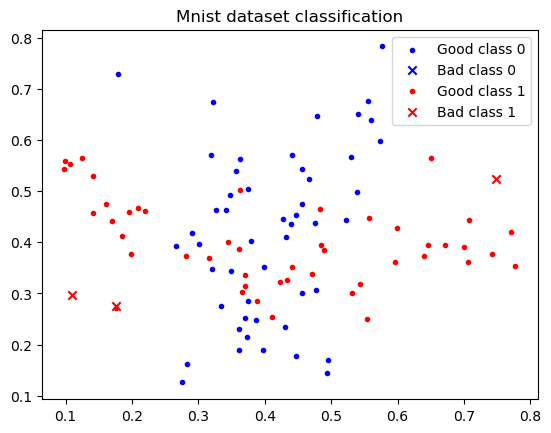

In [70]:
#plot whether the algo gives the correct outcome for each x, by 3rd and 4th variable in x
plt.scatter(x_b_good[:,2], x_b_good[:,3], c='b', marker=".", label="Good class 0")
plt.scatter(x_b_bad[:,2], x_b_bad[:,3], c='b', marker="x", label="Bad class 0")
plt.scatter(x_r_good[:,2], x_r_good[:,3], c='r', marker=".", label="Good class 1")
plt.scatter(x_r_bad[:,2], x_r_bad[:,3], c='r', marker="x", label="Bad class 1")

plt.title("Mnist dataset classification")
plt.legend()

**Variational Quantum Classifier**

This is the final section and finally we can play with the VQC.

We need to tune the VQC by trying different parameters until we get good results. The best parameters for VQC that is trained with QPCA dataset maybe (and by 'maybe' I mean high chance) different with the one that is trained with classical PCA. There are many good tutorials on VQC here https://github.com/qiskit-community/qiskit-community-tutorials/tree/master/machine_learning .

**Data embedding circuits**

C:\Users\sebts\AppData\Roaming\Python\Python39\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


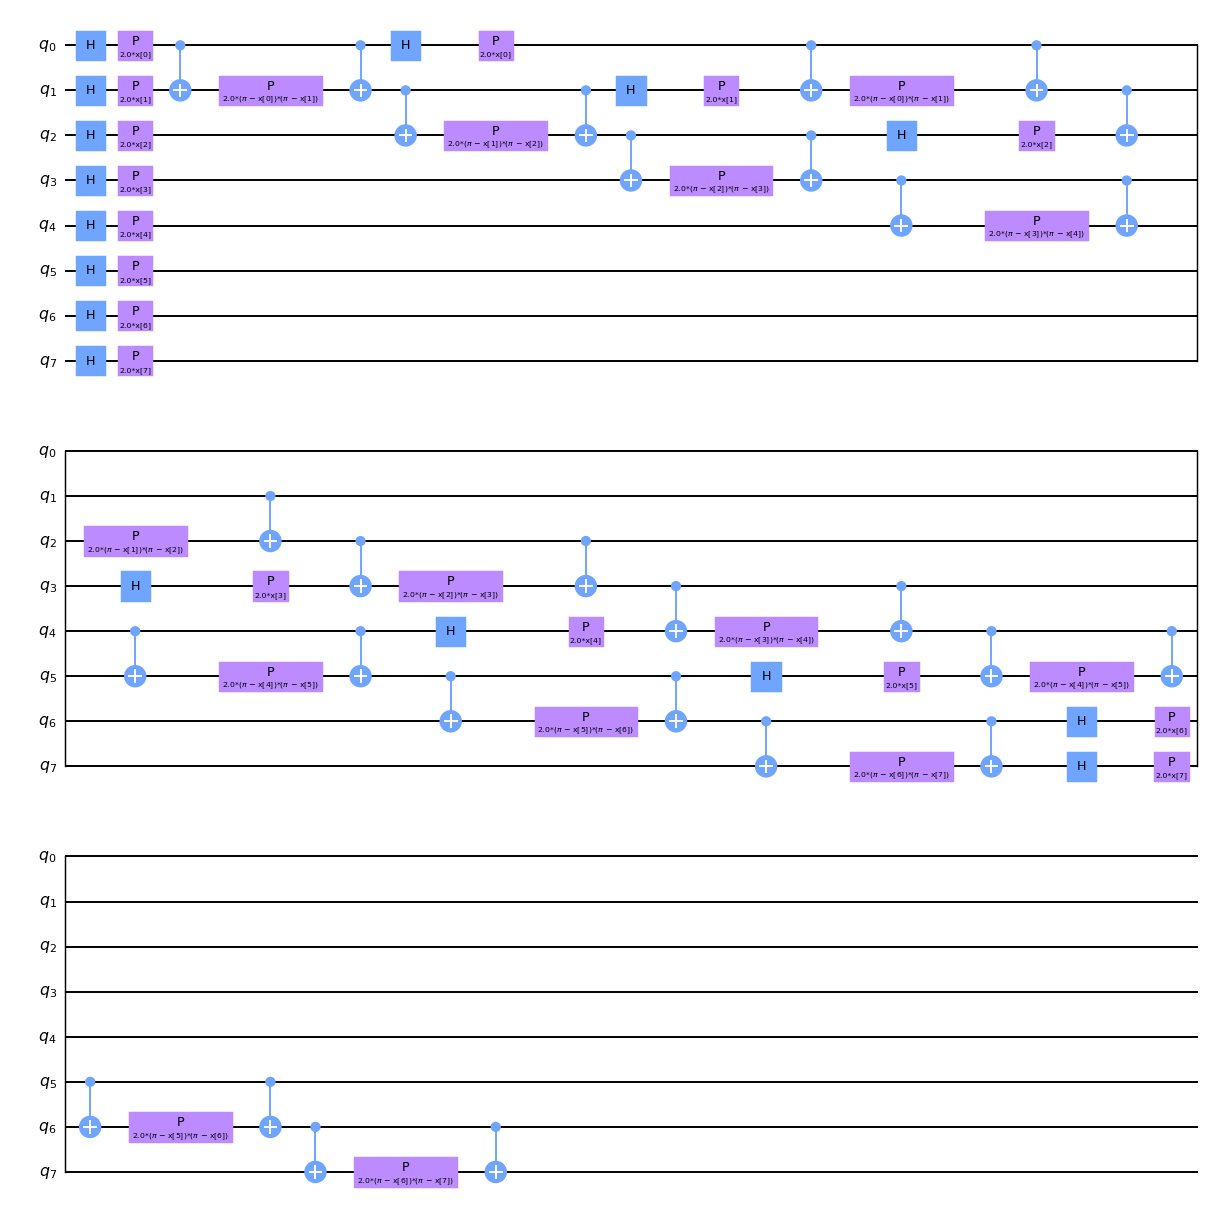

In [24]:
def get_zz_feature_map(feature_dim, feature_map_rep, ent): #this is our generic feature map for 8 components (qubits)
    return ZZFeatureMap(feature_dimension=feature_dim, reps=feature_map_rep, entanglement=ent)

fmap_zz = get_zz_feature_map(n_components_classic, 2, 'linear') #can't remember what rep is? possibly just visual rep depth
input_params = fmap_zz.parameters
fmap_zz.decompose().draw('mpl', scale=0.7)

In [25]:
fmap_zz.parameters #8 parameters to encode the 8 features of our reduced dimensionality data

ParameterView([ParameterVectorElement(x[0]), ParameterVectorElement(x[1]), ParameterVectorElement(x[2]), ParameterVectorElement(x[3]), ParameterVectorElement(x[4]), ParameterVectorElement(x[5]), ParameterVectorElement(x[6]), ParameterVectorElement(x[7])])

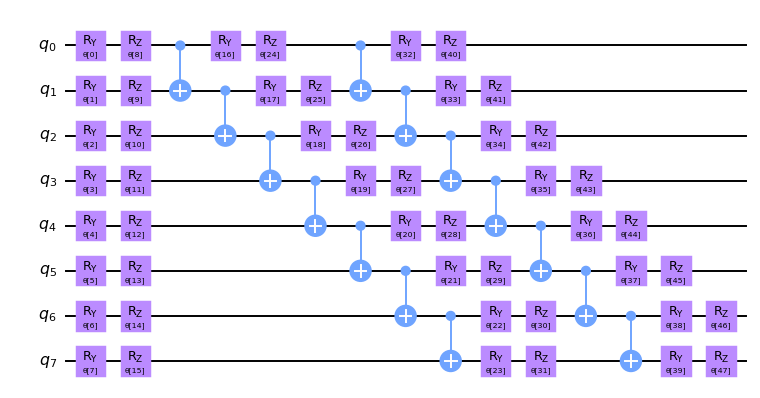

In [26]:
def get_two_locals(feature_dim, rotations, var_form_rep, ent): #sets up our general ansatz
    return TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)

ansatz_tl = get_two_locals(n_components_classic, ['ry', 'rz'], 2, 'linear') #do we just do ry and rz bc we have x in cx?
weights_params = ansatz_tl.parameters
ansatz_tl.decompose().draw('mpl', scale=0.7)

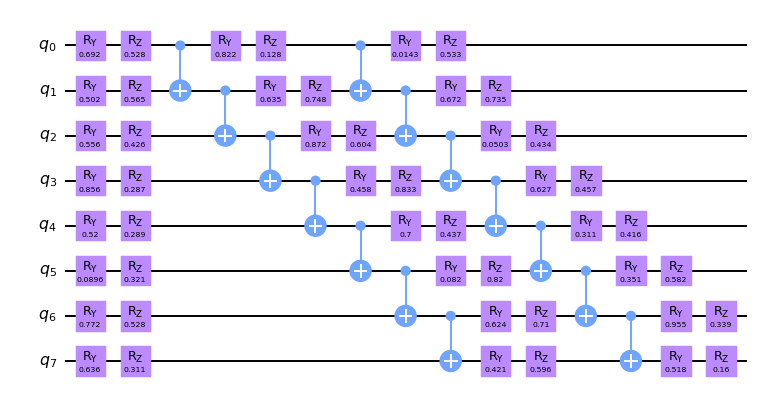

In [27]:
weights = np.random.random(len(ansatz_tl.parameters)) #get random weights from 0 to 1 for each rotation
ansatz_tl.assign_parameters({k:v for (k,v) in zip(ansatz_tl.parameters, weights)}).decompose().draw('mpl', scale=0.7)

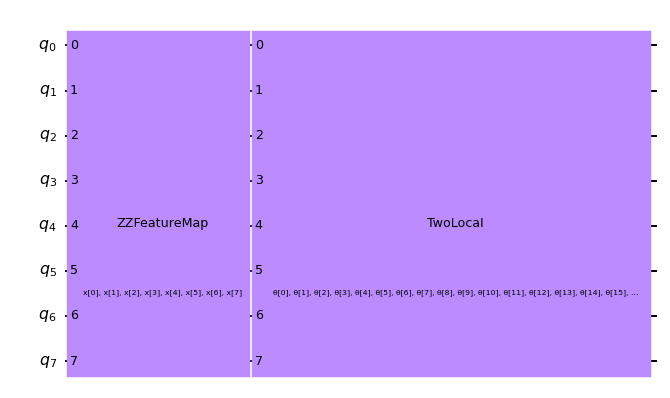

In [28]:
var_circuit = fmap_zz.compose(ansatz_tl) #variational circuit, I am not sure if there is more to the circuit past two local?
var_circuit.draw('mpl', scale=0.7)

**Primitives**

For info, see https://docs.quantum.ibm.com/run/primitives

In [29]:
#it seems like there might be better options for this? am I accessing the online simulator?

# for qiskit_ibm_runtime.Options, see https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.Options
qasm_sim = AerSimulator()
options = {}
sampler = BackendSampler(backend=qasm_sim, options=options)
estimator = BackendEstimator(backend=qasm_sim, options=options)

**Quantum Neural Network**

**SamplerQNN**

In [30]:
#these are the loss (or cost?) fns from the example, I think parity might work for more classes? but we only have two so can use one qubit binary?

def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [31]:
var_circuit_with_meas = var_circuit.copy()
var_circuit_with_meas.measure_all() #adds classical measurement (in Z?) to the circuit, I think this would be done automatically?

In [32]:
#is this just to define the parameterised ciruit sampler as the AerSimulator?
paramShiftSampGrad = ParamShiftSamplerGradient(sampler=sampler)

sampler_qnn = SamplerQNN(sampler=sampler, #calling the sampler again
                         circuit=var_circuit_with_meas, #this is our ciruit we built above
                         input_params=input_params, #from fmap_zz.parameters, I think this is where the 8 points per data set are put in
                                                           
                         weight_params=weights_params, #this is from our two local (ansatz_tl.parameters)
                                                           
                         interpret=one_qubit_binary, #the one qubit binary loss fn (same = 0, dif = 1)
                         output_shape=2, #gives us [a,b] output, not sure what this refers to? chance of 0 and 1?
                         gradient=paramShiftSampGrad) #why are we putting the sampler in again?


# if your embedding strategy is not a parametrized circuit
# (e.g. amplitude encoding) you will have to do some extra work!
# if you train your embedding as well, the trainable
# parameters of the embedding must be added

**Forward pass**

In [33]:
# The result of the neural network on a forward pass.
output = sampler_qnn.forward(x_total, weights) #(100, 8) the full (reduced) x data set, 
#weights = np.random.random(len(ansatz_tl.parameters)) -- our random set of starting parameters in the two local
print(f"Output shape for {len(x_total)} samples: {output.shape}")
print(f"Output of the forward pass for first sample: {output[0]}") #i think this is chance of outputting 0 or 1, 
                                                                   #but I am not sure if this means correct/wrong or 0,1 the pictures
                                                                   # I don't think this knows about y? so I think it's picture 0 or 1

Output shape for 100 samples: (100, 2)
Output of the forward pass for first sample: [0.66503906 0.33496094]


**Backward pass**

In [34]:
# The result of the neural network on a backward pass
_, weights_grad = sampler_qnn.backward(x_total, weights) #same thing but backwards
print(f"Output shape for {len(x_total)} samples: {weights_grad.shape}")
print(f"Output of the backward pass for first sample: {weights_grad[0]}") 
#these weights are the parameter values for the two local?
#but there's two sets of 48? (0 and 1 values?)


Output shape for 100 samples: (100, 2, 48)
Output of the backward pass for first sample: [[ 0.15136719  0.12011719  0.00732422  0.00585938 -0.00048828  0.00195312
   0.02246094  0.00585938  0.32519531  0.01171875 -0.00244141 -0.00732422
  -0.0078125  -0.00976562 -0.0234375  -0.00585938 -0.07080078 -0.02148438
   0.00097656  0.01757812 -0.01464844 -0.00976562  0.00048828  0.00830078
   0.0078125   0.00439453 -0.01074219 -0.00439453 -0.01269531 -0.00390625
  -0.01025391 -0.00244141 -0.01855469  0.00195312  0.00683594 -0.00195312
  -0.00976562  0.00488281  0.01611328  0.00830078 -0.00390625  0.00048828
   0.01074219 -0.0078125  -0.02929688 -0.00341797  0.00439453 -0.00244141]
 [-0.15136719 -0.12011719 -0.00732422 -0.00585938  0.00048828 -0.00195312
  -0.02246094 -0.00585938 -0.32519531 -0.01171875  0.00244141  0.00732422
   0.0078125   0.00976562  0.0234375   0.00585938  0.07080078  0.02148438
  -0.00097656 -0.01757812  0.01464844  0.00976562 -0.00048828 -0.00830078
  -0.0078125  -0.00439

**EstimatorQNN**

In [35]:
obs_parity = Pauli('Z' * n_components_classic)
obs_one_qubit = Pauli('I' * (n_components_classic - 1) + 'Z')
print(f"Parity observable: {obs_parity}")
print(f"First qubit observable: {obs_one_qubit}") #ahhh so these are our choices of observables to then turn into loss fn?

Parity observable: ZZZZZZZZ
First qubit observable: IIIIIIIZ


In [36]:
paramShiftEstGrad = ParamShiftEstimatorGradient(estimator=estimator) #this time we're using the estimator rather than sampler, this just does the matrices?

estimator_qnn = EstimatorQNN(estimator=estimator,
                             circuit=var_circuit,
                             observables=obs_one_qubit, #this time we're applying the observable (IIIIIIIZ) rather than 1 qubit binary
                                                        # i'm not sure how the 1 qubit binary in the sampler is calculated then
                                                        # possibly something to do with output shape?
                             
                             input_params=input_params,     # if your embedding strategy is not a parametrized circuit
                                                            # (e.g. amplitude encoding) you will have to do some extra work!
                             weight_params=weights_params,  # if you train your embedding as well, the trainable
                                                            # parameters of the embedding must be added
                             gradient=paramShiftEstGrad)

**Forward pass**

In [37]:
# The result of the neural network on a forward pass.
output = estimator_qnn.forward(x_total, weights)
print(f"Output shape for {len(x_total)} samples: {output.shape}")
print(f"Output of the forward pass for first sample: {output[0]}") 
#this time we're simply outputting the expectation value of the observable IIIIIIIZ

Output shape for 100 samples: (100, 1)
Output of the forward pass for first sample: [0.35546875]


**Backward pass**

In [38]:
# The result of the neural network on a backward pass
_, weights_grad = estimator_qnn.backward(x_total, weights)
print(f"Output shape for {len(x_total)} samples: {weights_grad.shape}")
print(f"Output of the backward pass for first sample: {weights_grad[0]}")
# i think these are directly the parameter values for two local?

Output shape for 100 samples: (100, 1, 48)
Output of the backward pass for first sample: [[ 0.33691406  0.23144531 -0.00195312  0.00195312 -0.0078125  -0.02832031
  -0.00097656  0.00097656  0.64355469  0.01953125 -0.00976562  0.02246094
  -0.01171875 -0.01464844  0.04101562  0.00195312 -0.13964844  0.00390625
  -0.00097656 -0.00292969  0.00097656 -0.00878906  0.01953125 -0.0078125
  -0.00195312  0.02636719  0.00878906 -0.03613281 -0.02539062 -0.00390625
  -0.04492188 -0.00976562 -0.0234375   0.01367188 -0.00585938  0.01367188
  -0.02734375  0.00683594  0.02636719  0.01367188 -0.00195312  0.01269531
   0.00390625  0.00488281 -0.01660156  0.00683594 -0.00097656 -0.0546875 ]]


**Train a Neural Network Classifier**

In [39]:
y_train #just our y data of if it's a 0 or 1

array([0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0], dtype=uint8)

In [40]:
def get_one_hot_encoding(y): #this converts the labels 0,1 to vectors |0>,|1> (maybe transpose)
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels), dtype=int)[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

print(f"Label {y_train[2]} converted to {y_train_1h[2]}")
print(f"Label {y_train[0]} converted to {y_train_1h[0]}")

Label 1 converted to [0 1]
Label 0 converted to [1 0]


In [41]:
def spsa_callback(nfev, params, fval, stepsize, accepted=None): #this is just to pull out loss every 3 iterations
    #doesn't use params or stepsize (i think it's hard set to 3 below)
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global spsa_loss_recorder

    if (nfev % 3) == 0:
        spsa_loss_recorder.append(fval)
        # print(f"SPSA Epoch {len(spsa_loss_recorder)}: {fval:.5f}")

In [46]:
x_train_small_pca.shape #previously had wrong x_train here, we want the reduced dimensionality set of 80

(80, 8)

In [43]:
y_train_1h.shape #2 bc we've converted into one hot encoding

(80, 2)

In [44]:
max_itr = 10
spsa_opt = SPSA(maxiter=max_itr, callback=spsa_callback) # from qiskit.algorithms.optimizers
spsa_loss_recorder = [] #empty list to append training loss into 
initial_point = np.random.random((len(ansatz_tl.parameters),)) #random starting parameter set for our twolocal ansatz

vqc = NeuralNetworkClassifier(neural_network=sampler_qnn, #SamplerQNN(sampler=sampler, circuit=var_circuit_with_meas,input_params=input_params,
                              # weight_params=weights_params, interpret=one_qubit_binary, output_shape=2,gradient=paramShiftSampGrad) 
                              # so outputs [a,b] vector, for a|0>+b|1> from 1st qubit?
                              one_hot=True, #does loss as vectors
                              optimizer=spsa_opt, #above
                              initial_point=initial_point) #random twolocal starting point

vqc = vqc.fit(x_train_small_pca, y_train_1h) #run, I think the .fit runs the training?

Text(0.5, 1.0, 'Training loss')

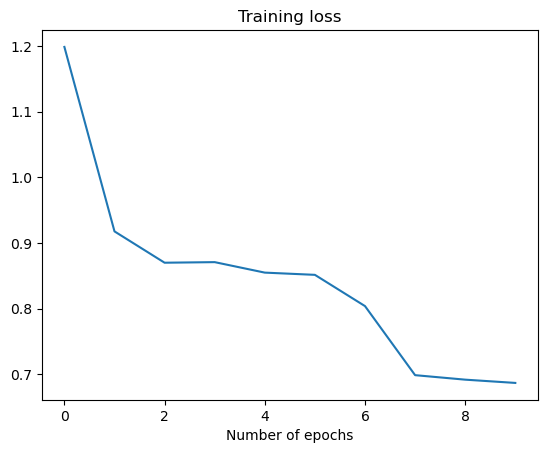

In [45]:
plt.plot(spsa_loss_recorder) #plots fval, I'm confused about the % 3 bc this would imply only every third point?
#maybe 3 per itteration? so 30 total?
plt.xlabel("Number of epochs")
plt.title("Training loss")

In [47]:
score_train = vqc.score(x_train_small_pca, y_train_1h) #how well does it run on the training set
score_test = vqc.score(x_test_small_pca, y_test_1h) #how well does it run on the test set (assesses how good in more general case)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

Score on the train set 0.8375
Score on the test set 0.9


In [48]:
y_train_pred = vqc.predict(x_train_small_pca) #what's the predicted y outcome [0,1] / [1,0] for pca'ed training data
y_test_pred = vqc.predict(x_test_small_pca) #same for test

In [49]:
#corret answer mask
train_pred_acc = np.all(y_train_pred == y_train_1h, axis=1)
test_pred_acc = np.all(y_test_pred == y_test_1h, axis=1)

In [54]:
train_pred_acc

array([False,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True, False, False,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True, False,  True, False,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True, False, False,  True,  True,  True])

In [50]:
#split x data by whether the trained algo will give correct answer
x_all = np.concatenate((x_train_small_pca, x_test_small_pca))
y_all= np.concatenate((y_train_1h, y_test_1h))
y_pred_acc_all = np.concatenate((train_pred_acc, test_pred_acc))

x_b = x_all[np.all(y_all == [1, 0], axis=1)]
x_b_good = x_b[(y_pred_acc_all[np.all(y_all == [1, 0], axis=1)])]
x_b_bad = x_b[np.logical_not(y_pred_acc_all[np.all(y_all == [1, 0], axis=1)])]

x_r = x_all[np.all(y_all == [0, 1], axis=1)]
x_r_good = x_r[(y_pred_acc_all[np.all(y_all == [0, 1], axis=1)])]
x_r_bad = x_r[np.logical_not(y_pred_acc_all[np.all(y_all == [0, 1], axis=1)])]

In [52]:
x_b_good.shape #good 0's, all x data?

(32, 8)

In [53]:
x_b_good[0] #the 8 parameters for this data set

array([0.5717578 , 0.0197521 , 0.4566309 , 0.54267925, 0.38951346,
       0.33407667, 0.17543308, 0.5658302 ], dtype=float32)

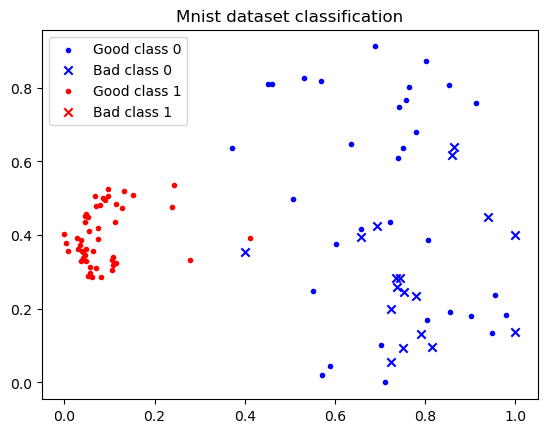

In [51]:
#plot whether the algo gives the correct outcome for each x, by the first two variables in x
plt.scatter(x_b_good[:,0], x_b_good[:,1], c='b', marker=".", label="Good class 0")
plt.scatter(x_b_bad[:,0], x_b_bad[:,1], c='b', marker="x", label="Bad class 0")
plt.scatter(x_r_good[:,0], x_r_good[:,1], c='r', marker=".", label="Good class 1")
plt.scatter(x_r_bad[:,0], x_r_bad[:,1], c='r', marker="x", label="Bad class 1")

plt.title("Mnist dataset classification")
plt.legend()

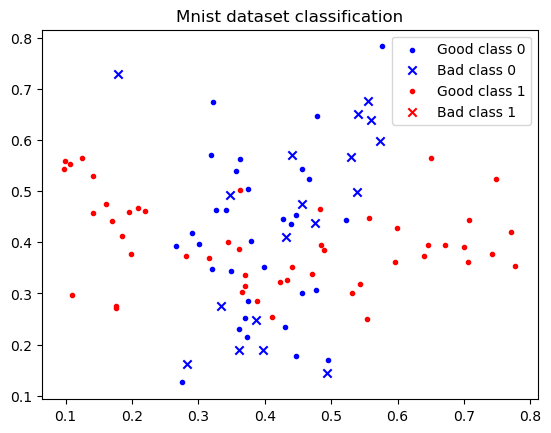

In [55]:
#plot whether the algo gives the correct outcome for each x, by 3rd and 4th variable in x
plt.scatter(x_b_good[:,2], x_b_good[:,3], c='b', marker=".", label="Good class 0")
plt.scatter(x_b_bad[:,2], x_b_bad[:,3], c='b', marker="x", label="Bad class 0")
plt.scatter(x_r_good[:,2], x_r_good[:,3], c='r', marker=".", label="Good class 1")
plt.scatter(x_r_bad[:,2], x_r_bad[:,3], c='r', marker="x", label="Bad class 1")

plt.title("Mnist dataset classification")
plt.legend()